In [1]:
###Import important packages
!pip install transformers &> /dev/null
from transformers import BertTokenizer, BertModel
import torch
import torch. nn as nn
import pandas as pd
import numpy as np
import glob
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
###Define global variables
BASEPATH = "" # Set working directory
device = "cuda:0" if torch.cuda.is_available() else "cpu" # Device to use GPU if available
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased') # Get pretrained word embedding 
bert_model = BertModel.from_pretrained('bert-base-german-cased').to(device) # Get pretrained BERT model
STOCK_ONLY = False #If True means predict only based on values of stock market (without using news)
EMBEDDING_DIM = 769 # Embedding dimension (768 - BERT embedding, 1 - DAX index )
HIDDEN_DIM = 120 # Hidden dimension
SEQ_LEN = 15 # Sequence length
N_EPOCHS = 100 # Number of epochs
patience = 30 # How long to wait after last time validation loss improved
num_runs = 10 # Number of trials
run_types = [True, False] # If True - stock only,if False stock plus text
def get_document_embedding(document):
  '''
  Get document embedding using pretrained German BERT model and  German BERT tokenizer
  Args:
      document (str): textual document which has to be transformed 
  '''
  with torch.no_grad(): #Do not calculate gradients
    #Tokenize the dataset, truncate when passed `max_length`,and pad with 0's when less than `max_length`,save as pytorch  return_tensors,
    inputs = tokenizer(document, return_tensors="pt", max_length=512, truncation=True)
    inputs.to(device)# To GPU if available
    outputs = bert_model(**inputs) # Get BERT embedding
    document_embedding = outputs.last_hidden_state[0][0] # Select CLS token (always first one)
    document_embedding = document_embedding.unsqueeze_(0) # Return horisontal position of tensor, underscore means no new memory is being allocated by doing the operation, which in general increase performance 
    return document_embedding
def get_day_embedding(document_list, up_down, no_text):
  '''
  Get day embedding using embedding from devied above function get_day_embedding
  Args:
      document_list (list): list of documents for one day
      up_down (numeric): if DAX index increases (1) or not (0)
      no_text (binary): True means predict only based on values of stock market (without using news)
  '''
  if no_text == True:
    day_embedding = torch.rand(1, 768).to(device)# Get random embedding
  else:
    document_embeddings = get_document_embedding(document_list[0]).unsqueeze_(0) # Store first embedding
    for document in document_list[1:]:
      document_embeddings = torch.cat([document_embeddings, get_document_embedding(document).unsqueeze_(0)],0)#Concatenate all embeddings for one day 
    day_embedding = torch.mean(document_embeddings, dim=0) # Calculate mean for one day 
  day_embedding = torch.cat([day_embedding, torch.tensor([[up_down]]).to(device)],1) # Merge DAX index as last value of embedding
  return day_embedding
def embeddings_to_tensor(sequence):
  '''
  Pass in slice from input, return tensor of embeddings [SEQ_LEN, EMBEDDING_DIM]
  Args:
      sequence (numeric): input sequence (embedding)
  '''
  sequence_tensor = sequence[0:1]["Embedding"][0] # Store first embedding
  for index, row in sequence[1:].iterrows():
    sequence_tensor = torch.cat([sequence_tensor, row["Embedding"]],0) # Concatenate all embeddings for one day 
  sequence_tensor.to(device) # To GPU if available
  return sequence_tensor

def columns_to_tensor(sequence):
  '''
  Pass in slice from output
  Args:
      sequence (numeric): output sequence
  '''
  sequence_tensor = torch.tensor(sequence[0:1]["Up"], dtype=torch.float)# Store first output
  for index, row in sequence[1:].iterrows():
    sequence_tensor = torch.cat([sequence_tensor,torch.tensor(row["Up"], dtype=torch.long).unsqueeze_(0)],0)# Concatenate output for one day 
  sequence_tensor.to(device) # To GPU if available
  return sequence_tensor


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
def prepare_data(news_filename, news_encoding):
  # Read dataframe with DAX stock market, drom missing values and create two binary variables: Up - if closing DAX index is larger than opening, PrevUP - shifted index for next day
  dax = pd.read_csv(BASEPATH + "DAX.csv")
  dax = dax.dropna()
  dax["Up"] = np.where(dax['Open']<dax['Close'], 1, 0)
  dax["PrevUp"] = dax.Up.shift(1)
  dax["Date"] = pd.to_datetime(dax["Date"])
  # Read file with articles (headlines) and create suitable date format
  news_file = pd.read_csv(BASEPATH + news_filename, sep="\t", encoding=news_encoding)
  news_file["Date"] = news_file["Year"].astype(str) + "-" + news_file["Month"].astype(str) + "-" + news_file["Day"].astype(str)
  news_file["Date"] = pd.to_datetime(news_file["Date"])
  # Merge table with articles and table with DAX index
  news_file = pd.merge(news_file, dax, how="inner", on="Date")
  # Connect headlines and subheadlines as variable Headline
  news_file["Headline"] = news_file["Headline"].fillna("")
  news_file["Article"] = news_file["Article"].fillna("")
  news_file["Headline"] = news_file["Headline"].astype(str) + " " + news_file["Article"].astype(str)
  # Aggregate Headlines as list
  news_file = news_file.groupby("Date").agg({"Headline":list,"Up":"first","PrevUp":"first"})
  news_file["ArticleCount"] = news_file.Headline.apply(len)
  # Sort by date and keep anly articles between 01.01.2014 and 01.03.2020
  news_file = news_file.sort_values("Date")
  news_file["Headline"] = news_file.Headline.apply(np.array)
  news_file = news_file.loc[news_file.index > datetime(2014,1,1)]
  news_file = news_file.loc[news_file.index < datetime(2020,3,1)]
  # Train test validation split (80%, 10%, 10%)
  news_file_train = news_file.iloc[0:int(len(news_file)*0.8)]
  news_file_validation = news_file.iloc[int(len(news_file)*0.8):int(len(news_file)*0.9)]
  news_file_test = news_file.iloc[int(len(news_file)*0.9):int(len(news_file))]
  # Get day embedding for train, test, and validation sets
  news_file_train["Embedding"] = news_file_train.apply(lambda x: get_day_embedding(x.Headline, x.PrevUp, STOCK_ONLY), axis=1)
  news_file_validation["Embedding"] = news_file_validation.apply(lambda x: get_day_embedding(x.Headline, x.PrevUp, STOCK_ONLY), axis=1)
  news_file_test["Embedding"] = news_file_test.apply(lambda x: get_day_embedding(x.Headline, x.PrevUp, STOCK_ONLY), axis=1)
  return news_file_train, news_file_validation, news_file_test

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    #Compare the loss and calculate the stopping counter, else save function
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    #Function to save the best model
    def save_checkpoint(self, val_loss, model):
        #Saves model when validation loss decrease
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [4]:
class LSTM_Classifier(nn.Module):
    '''
    Define LSTM Classifier, inheritance from nn.Module
    '''
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        super(LSTM_Classifier, self).__init__()
        self.hidden_dim = hidden_dim # The number of features in the hidden state h.
        self.init_hidden() # Define hidden state
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1) # Define LSTM layer
        self.dropout = nn.Dropout(p=0.2) # Define layers with dropout
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size) # The linear layer that maps from hidden state space to tag space 
    def init_hidden(self):
        # Define hidden layer
        self.hidden = (torch.zeros((1, 1, self.hidden_dim), requires_grad=False).to(device), torch.zeros((1, 1, self.hidden_dim), requires_grad=False).to(device))    
    def forward(self, inputs):
        sequence, (hx, cx) = inputs # Inputs of shape (batch, input_size)
        embeds = embeddings_to_tensor(sequence) # Pass in slice from input, return tensor of embeddings [SEQ_LEN, EMBEDDING_DIM]
        lstm_out, (hx, cx) = self.lstm(embeds.view(len(sequence), 1, -1), (hx, cx)) # Place to lstm, hiiden and cell  state
        lstm_out = self.dropout(lstm_out) # Pass in dropout
        tag_space = self.hidden2tag(lstm_out.view(len(sequence), -1)) # The linear layer that maps from hidden state space to tag space 
        tag_scores = torch.sigmoid(tag_space) # Predictions
        return tag_scores, (hx, cx)

In [5]:
def train_model(model, patience):
  """
  Train model
  Args:
    model: model to train
    patience (int): How long to wait after last time validation loss improved
  """
  #Lists to collect train and validation loss
  train_losses = []
  valid_losses = []
  avg_train_losses = []
  avg_valid_losses = []
  # Early stopping
  early_stopping = EarlyStopping(patience=patience, verbose=True, path=BASEPATH+"/checkpoint.pt")
  #Start fine tuning
  for epoch in range(N_EPOCHS+1):
      model.train()
      model.init_hidden()
      for x in range(int(len(train)/SEQ_LEN)):
          model.zero_grad() # Zeros the gradients accumulated from the previous step
          targets = columns_to_tensor(train[x*SEQ_LEN:(x+1)*SEQ_LEN])
          targets.to(device) # To GPU if available
          tag_scores, model.hidden = model((train[x*SEQ_LEN:(x+1)*SEQ_LEN], model.hidden))
          tag_scores.to(device) # To GPU if available
          model.hidden = (model.hidden[0].detach(), model.hidden[1].detach()) # Calculate a hidden
          loss = loss_function(torch.flatten(tag_scores).to(device), targets.to(device)) # Calculate a loss
          loss.to(device) # To GPU if available
          loss.backward() # Performs backpropagation 
          torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25) # Gradient norm
          optimizer.step() # Updates the weights in our neural network based on the results of backpropagation
          train_losses.append(loss.item())
      model.eval()
      model.init_hidden()
      for x in range(int(len(validation)/SEQ_LEN)):
          model.zero_grad() # Zeros the gradients accumulated from the previous step
          targets = columns_to_tensor(validation[x*SEQ_LEN:(x+1)*SEQ_LEN])
          targets.to(device) # To GPU if available
          #print(targets)
          tag_scores, model.hidden = model((validation[x*SEQ_LEN:(x+1)*SEQ_LEN], model.hidden))
          #print(torch.flatten(tag_scores))
          test_loss = loss_function(torch.flatten(tag_scores).to(device), targets.to(device))
          test_loss.to(device) # To GPU if available
          valid_losses.append(test_loss.item())
          model.hidden = (model.hidden[0].detach(), model.hidden[1].detach())
      # Print training/validation statistics and calculate average loss over an epoch
      train_loss = np.average(train_losses)
      valid_loss = np.average(valid_losses)
      avg_train_losses.append(train_loss)
      avg_valid_losses.append(valid_loss)  
      epoch_len = len(str(N_EPOCHS))
      print_msg = (f'[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')
      print(print_msg)
      # Clear lists to track next epoch
      train_losses = []
      valid_losses = []
      # Early_stopping needs the validation loss to check if it has decresed, and if it has, it will make a checkpoint of the current model
      early_stopping(valid_loss, model)
      if early_stopping.early_stop:
          print("Early stopping")
          break     
  # Load the last checkpoint with the best model
  model.load_state_dict(torch.load(BASEPATH+"/checkpoint.pt"))
  return  model, avg_train_losses, avg_valid_losses

In [6]:
def eval_model(model, test):
  '''
  Evaluate model
    Args:
    model: model to train
    test (dataframe): data frame
  '''
  eval_list = []
  model.eval()
  model.init_hidden()
  for x in range(int(len(test)/SEQ_LEN)):
      model.zero_grad()
      targets = columns_to_tensor(test[x*SEQ_LEN:(x+1)*SEQ_LEN])
      targets.to(device)
      tag_scores, model.hidden = model((test[x*SEQ_LEN:(x+1)*SEQ_LEN], model.hidden))
      result = targets.to(device) == (torch.flatten(tag_scores)>0.5)
      result = result.double()
      result = torch.sum(result).item()/SEQ_LEN
      eval_list.append(result)
      model.hidden = (model.hidden[0].detach(), model.hidden[1].detach())
  accuracy = sum(eval_list)/len(eval_list)
  return accuracy
def plot_loss(train_loss, valid_loss, run_type, run_num):
  '''
  Visualize the loss as the network trained
    Args:
    train_loss (list): train loss
    valid_loss (list): valid loss
    run_type (list): if True - stock only,if False stock plus text
    run_num (int): number of trials
  '''
  fig = plt.figure(figsize=(10,8))
  plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
  plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')
  # Find position of lowest validation loss
  minposs = valid_loss.index(min(valid_loss))+1 
  plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.ylim(0.6, 0.75) # Consistent scale
  plt.xlim(0, len(train_loss)+1) # Consistent scale
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  if run_type == True:
    run_type_str = "stock_only"
  else:
    run_type_str = "stock_plus_text"
  fig.savefig(BASEPATH+'/loss_plot_'+run_type_str+'_run_no_'+str(run_num)+'.png', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

[  0/100] train_loss: 0.69712 valid_loss: 0.69407
Validation loss decreased (inf --> 0.694074).  Saving model ...
[  1/100] train_loss: 0.69873 valid_loss: 0.69590
EarlyStopping counter: 1 out of 30
[  2/100] train_loss: 0.69503 valid_loss: 0.69588
EarlyStopping counter: 2 out of 30
[  3/100] train_loss: 0.69344 valid_loss: 0.69475
EarlyStopping counter: 3 out of 30
[  4/100] train_loss: 0.69390 valid_loss: 0.69352
Validation loss decreased (0.694074 --> 0.693523).  Saving model ...
[  5/100] train_loss: 0.69230 valid_loss: 0.69439
EarlyStopping counter: 1 out of 30
[  6/100] train_loss: 0.69283 valid_loss: 0.69340
Validation loss decreased (0.693523 --> 0.693400).  Saving model ...
[  7/100] train_loss: 0.69117 valid_loss: 0.69558
EarlyStopping counter: 1 out of 30
[  8/100] train_loss: 0.68999 valid_loss: 0.69519
EarlyStopping counter: 2 out of 30
[  9/100] train_loss: 0.68993 valid_loss: 0.69527
EarlyStopping counter: 3 out of 30
[ 10/100] train_loss: 0.68810 valid_loss: 0.69688
Ear

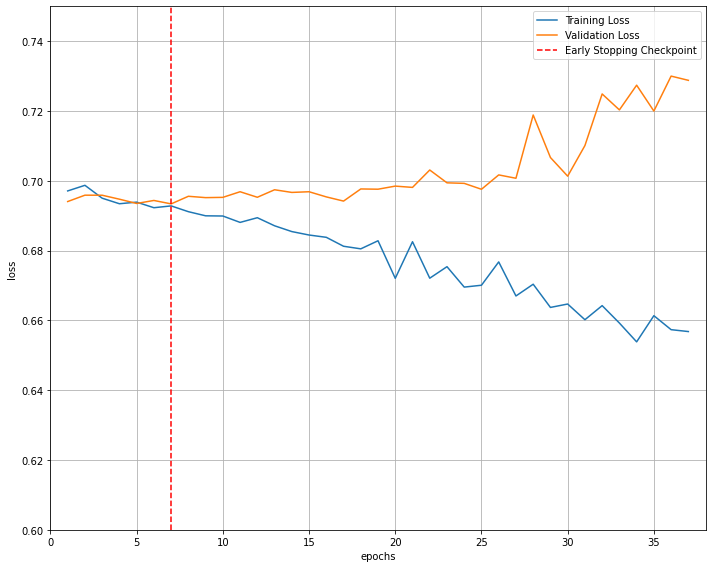

[  0/100] train_loss: 0.69480 valid_loss: 0.69531
Validation loss decreased (inf --> 0.695305).  Saving model ...
[  1/100] train_loss: 0.69421 valid_loss: 0.69538
EarlyStopping counter: 1 out of 30
[  2/100] train_loss: 0.69518 valid_loss: 0.69469
Validation loss decreased (0.695305 --> 0.694687).  Saving model ...
[  3/100] train_loss: 0.69320 valid_loss: 0.69469
EarlyStopping counter: 1 out of 30
[  4/100] train_loss: 0.69436 valid_loss: 0.69407
Validation loss decreased (0.694687 --> 0.694066).  Saving model ...
[  5/100] train_loss: 0.69283 valid_loss: 0.69526
EarlyStopping counter: 1 out of 30
[  6/100] train_loss: 0.69079 valid_loss: 0.69549
EarlyStopping counter: 2 out of 30
[  7/100] train_loss: 0.69281 valid_loss: 0.69583
EarlyStopping counter: 3 out of 30
[  8/100] train_loss: 0.68895 valid_loss: 0.69456
EarlyStopping counter: 4 out of 30
[  9/100] train_loss: 0.68863 valid_loss: 0.69501
EarlyStopping counter: 5 out of 30
[ 10/100] train_loss: 0.69000 valid_loss: 0.69789
Ear

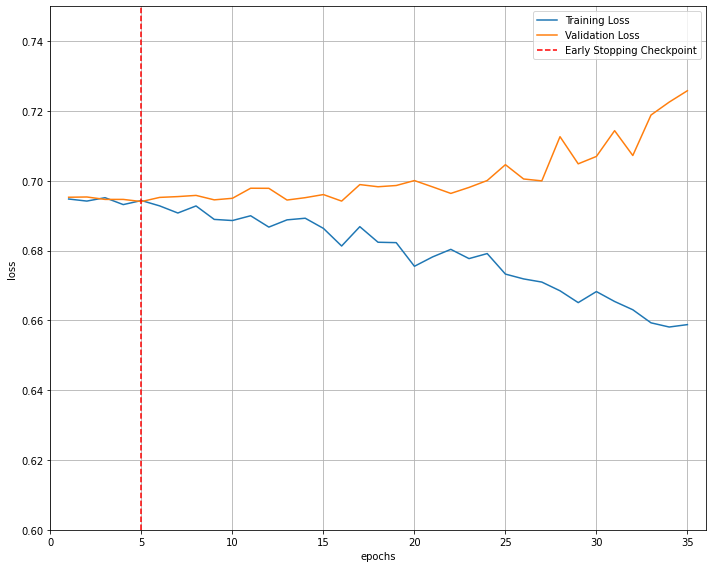

[  0/100] train_loss: 0.69711 valid_loss: 0.69941
Validation loss decreased (inf --> 0.699412).  Saving model ...
[  1/100] train_loss: 0.69808 valid_loss: 0.69859
Validation loss decreased (0.699412 --> 0.698594).  Saving model ...
[  2/100] train_loss: 0.69681 valid_loss: 0.69826
Validation loss decreased (0.698594 --> 0.698261).  Saving model ...
[  3/100] train_loss: 0.69388 valid_loss: 0.69737
Validation loss decreased (0.698261 --> 0.697367).  Saving model ...
[  4/100] train_loss: 0.69563 valid_loss: 0.69627
Validation loss decreased (0.697367 --> 0.696272).  Saving model ...
[  5/100] train_loss: 0.69273 valid_loss: 0.69761
EarlyStopping counter: 1 out of 30
[  6/100] train_loss: 0.69501 valid_loss: 0.69883
EarlyStopping counter: 2 out of 30
[  7/100] train_loss: 0.69244 valid_loss: 0.69685
EarlyStopping counter: 3 out of 30
[  8/100] train_loss: 0.69253 valid_loss: 0.69657
EarlyStopping counter: 4 out of 30
[  9/100] train_loss: 0.69067 valid_loss: 0.69699
EarlyStopping counte

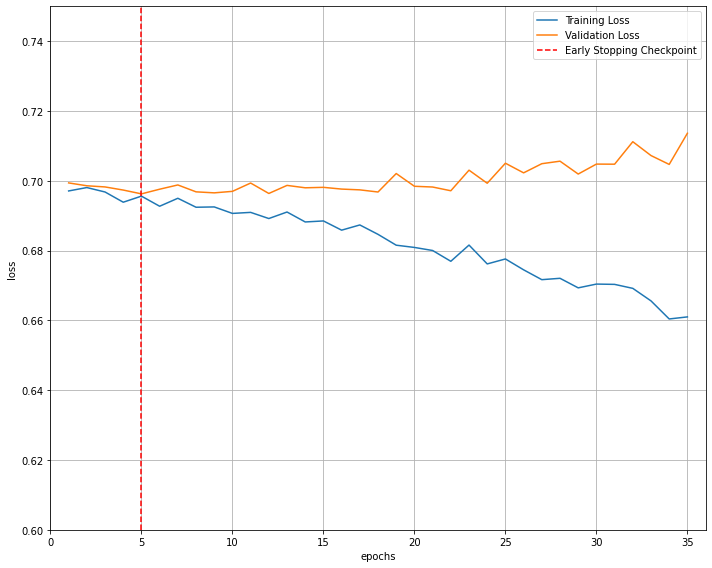

[  0/100] train_loss: 0.69687 valid_loss: 0.69631
Validation loss decreased (inf --> 0.696308).  Saving model ...
[  1/100] train_loss: 0.69708 valid_loss: 0.69649
EarlyStopping counter: 1 out of 30
[  2/100] train_loss: 0.69476 valid_loss: 0.69494
Validation loss decreased (0.696308 --> 0.694944).  Saving model ...
[  3/100] train_loss: 0.69384 valid_loss: 0.69329
Validation loss decreased (0.694944 --> 0.693289).  Saving model ...
[  4/100] train_loss: 0.69333 valid_loss: 0.69504
EarlyStopping counter: 1 out of 30
[  5/100] train_loss: 0.69400 valid_loss: 0.69554
EarlyStopping counter: 2 out of 30
[  6/100] train_loss: 0.69262 valid_loss: 0.69466
EarlyStopping counter: 3 out of 30
[  7/100] train_loss: 0.68960 valid_loss: 0.69619
EarlyStopping counter: 4 out of 30
[  8/100] train_loss: 0.69010 valid_loss: 0.69658
EarlyStopping counter: 5 out of 30
[  9/100] train_loss: 0.69181 valid_loss: 0.69611
EarlyStopping counter: 6 out of 30
[ 10/100] train_loss: 0.68851 valid_loss: 0.69504
Ear

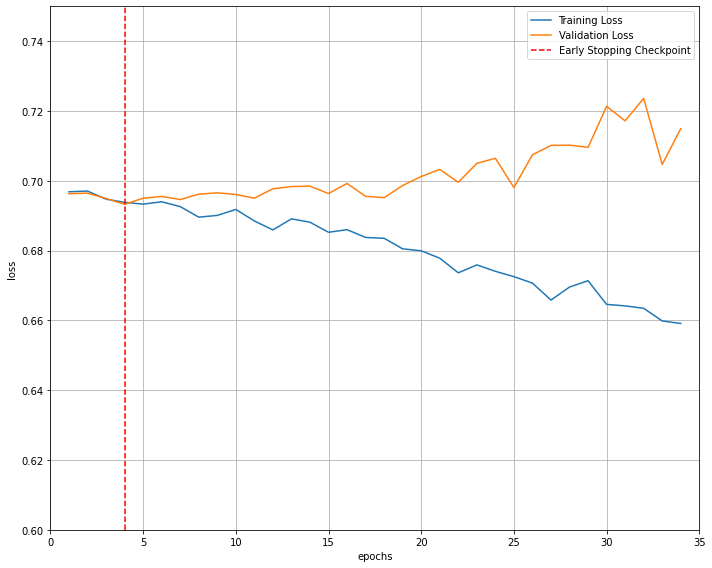

[  0/100] train_loss: 0.69716 valid_loss: 0.70104
Validation loss decreased (inf --> 0.701037).  Saving model ...
[  1/100] train_loss: 0.69653 valid_loss: 0.69831
Validation loss decreased (0.701037 --> 0.698315).  Saving model ...
[  2/100] train_loss: 0.69297 valid_loss: 0.69977
EarlyStopping counter: 1 out of 30
[  3/100] train_loss: 0.69332 valid_loss: 0.69728
Validation loss decreased (0.698315 --> 0.697284).  Saving model ...
[  4/100] train_loss: 0.69106 valid_loss: 0.69838
EarlyStopping counter: 1 out of 30
[  5/100] train_loss: 0.69152 valid_loss: 0.69758
EarlyStopping counter: 2 out of 30
[  6/100] train_loss: 0.68817 valid_loss: 0.69886
EarlyStopping counter: 3 out of 30
[  7/100] train_loss: 0.69109 valid_loss: 0.69843
EarlyStopping counter: 4 out of 30
[  8/100] train_loss: 0.69198 valid_loss: 0.69698
Validation loss decreased (0.697284 --> 0.696981).  Saving model ...
[  9/100] train_loss: 0.68950 valid_loss: 0.69668
Validation loss decreased (0.696981 --> 0.696682).  Sa

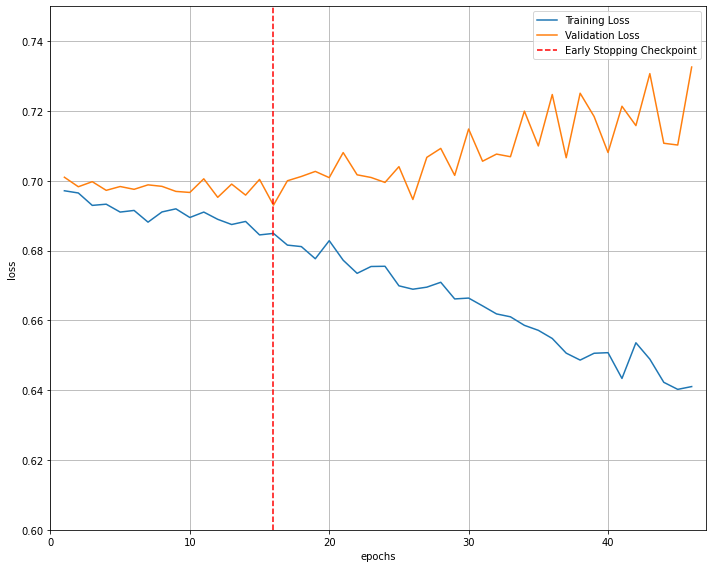

[  0/100] train_loss: 0.69693 valid_loss: 0.69931
Validation loss decreased (inf --> 0.699314).  Saving model ...
[  1/100] train_loss: 0.69381 valid_loss: 0.69994
EarlyStopping counter: 1 out of 30
[  2/100] train_loss: 0.69322 valid_loss: 0.69952
EarlyStopping counter: 2 out of 30
[  3/100] train_loss: 0.69265 valid_loss: 0.70031
EarlyStopping counter: 3 out of 30
[  4/100] train_loss: 0.69366 valid_loss: 0.69874
Validation loss decreased (0.699314 --> 0.698738).  Saving model ...
[  5/100] train_loss: 0.69062 valid_loss: 0.70097
EarlyStopping counter: 1 out of 30
[  6/100] train_loss: 0.69514 valid_loss: 0.70008
EarlyStopping counter: 2 out of 30
[  7/100] train_loss: 0.69060 valid_loss: 0.70095
EarlyStopping counter: 3 out of 30
[  8/100] train_loss: 0.68871 valid_loss: 0.70044
EarlyStopping counter: 4 out of 30
[  9/100] train_loss: 0.68894 valid_loss: 0.70110
EarlyStopping counter: 5 out of 30
[ 10/100] train_loss: 0.68813 valid_loss: 0.70102
EarlyStopping counter: 6 out of 30
[ 

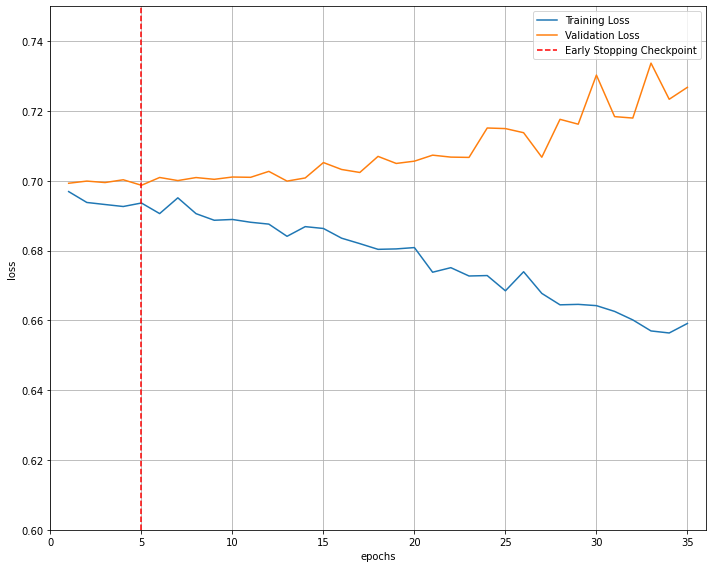

[  0/100] train_loss: 0.69740 valid_loss: 0.69572
Validation loss decreased (inf --> 0.695722).  Saving model ...
[  1/100] train_loss: 0.69591 valid_loss: 0.69780
EarlyStopping counter: 1 out of 30
[  2/100] train_loss: 0.69536 valid_loss: 0.69711
EarlyStopping counter: 2 out of 30
[  3/100] train_loss: 0.69323 valid_loss: 0.69473
Validation loss decreased (0.695722 --> 0.694726).  Saving model ...
[  4/100] train_loss: 0.69242 valid_loss: 0.69420
Validation loss decreased (0.694726 --> 0.694202).  Saving model ...
[  5/100] train_loss: 0.69263 valid_loss: 0.69497
EarlyStopping counter: 1 out of 30
[  6/100] train_loss: 0.69284 valid_loss: 0.69285
Validation loss decreased (0.694202 --> 0.692851).  Saving model ...
[  7/100] train_loss: 0.68909 valid_loss: 0.69416
EarlyStopping counter: 1 out of 30
[  8/100] train_loss: 0.69046 valid_loss: 0.69175
Validation loss decreased (0.692851 --> 0.691754).  Saving model ...
[  9/100] train_loss: 0.69161 valid_loss: 0.69246
EarlyStopping counte

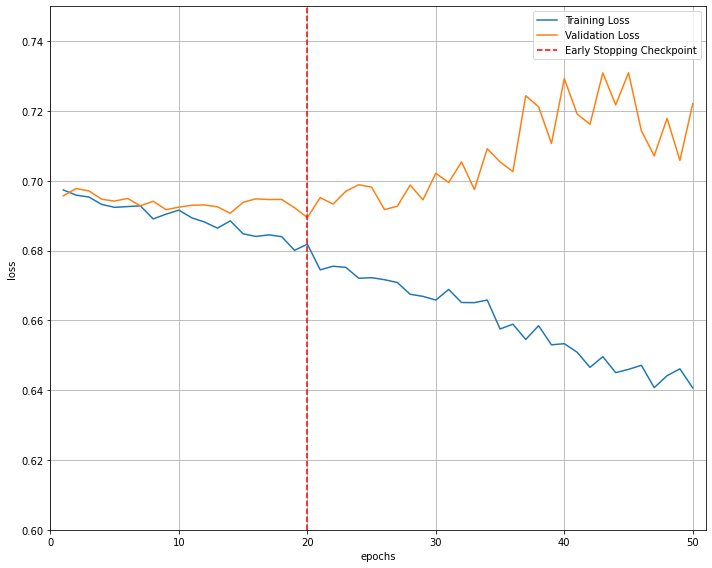

[  0/100] train_loss: 0.69808 valid_loss: 0.69521
Validation loss decreased (inf --> 0.695207).  Saving model ...
[  1/100] train_loss: 0.69759 valid_loss: 0.69545
EarlyStopping counter: 1 out of 30
[  2/100] train_loss: 0.69600 valid_loss: 0.69415
Validation loss decreased (0.695207 --> 0.694151).  Saving model ...
[  3/100] train_loss: 0.69304 valid_loss: 0.69475
EarlyStopping counter: 1 out of 30
[  4/100] train_loss: 0.69306 valid_loss: 0.69514
EarlyStopping counter: 2 out of 30
[  5/100] train_loss: 0.69217 valid_loss: 0.69614
EarlyStopping counter: 3 out of 30
[  6/100] train_loss: 0.69250 valid_loss: 0.69635
EarlyStopping counter: 4 out of 30
[  7/100] train_loss: 0.69180 valid_loss: 0.69566
EarlyStopping counter: 5 out of 30
[  8/100] train_loss: 0.69102 valid_loss: 0.69503
EarlyStopping counter: 6 out of 30
[  9/100] train_loss: 0.68941 valid_loss: 0.69411
Validation loss decreased (0.694151 --> 0.694112).  Saving model ...
[ 10/100] train_loss: 0.68832 valid_loss: 0.69749
Ear

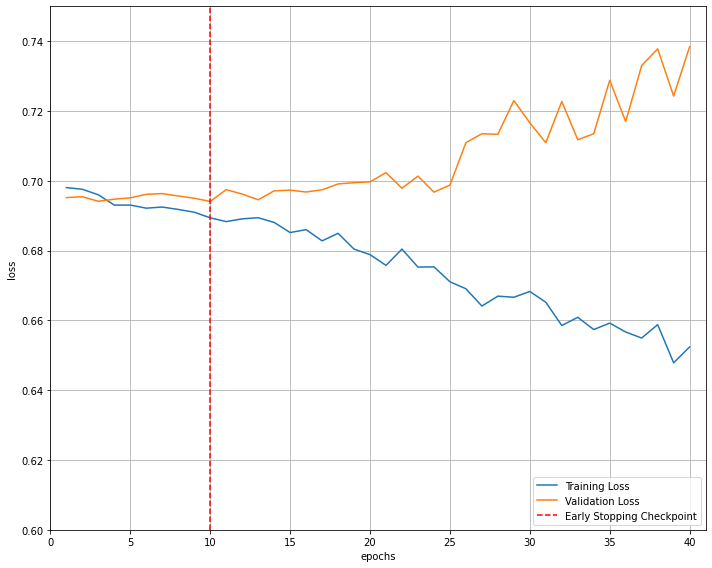

[  0/100] train_loss: 0.69589 valid_loss: 0.69622
Validation loss decreased (inf --> 0.696219).  Saving model ...
[  1/100] train_loss: 0.69666 valid_loss: 0.69491
Validation loss decreased (0.696219 --> 0.694908).  Saving model ...
[  2/100] train_loss: 0.69413 valid_loss: 0.69555
EarlyStopping counter: 1 out of 30
[  3/100] train_loss: 0.69458 valid_loss: 0.69417
Validation loss decreased (0.694908 --> 0.694174).  Saving model ...
[  4/100] train_loss: 0.69473 valid_loss: 0.69421
EarlyStopping counter: 1 out of 30
[  5/100] train_loss: 0.69259 valid_loss: 0.69494
EarlyStopping counter: 2 out of 30
[  6/100] train_loss: 0.69082 valid_loss: 0.69484
EarlyStopping counter: 3 out of 30
[  7/100] train_loss: 0.69047 valid_loss: 0.69427
EarlyStopping counter: 4 out of 30
[  8/100] train_loss: 0.68997 valid_loss: 0.69466
EarlyStopping counter: 5 out of 30
[  9/100] train_loss: 0.69008 valid_loss: 0.69398
Validation loss decreased (0.694174 --> 0.693981).  Saving model ...
[ 10/100] train_los

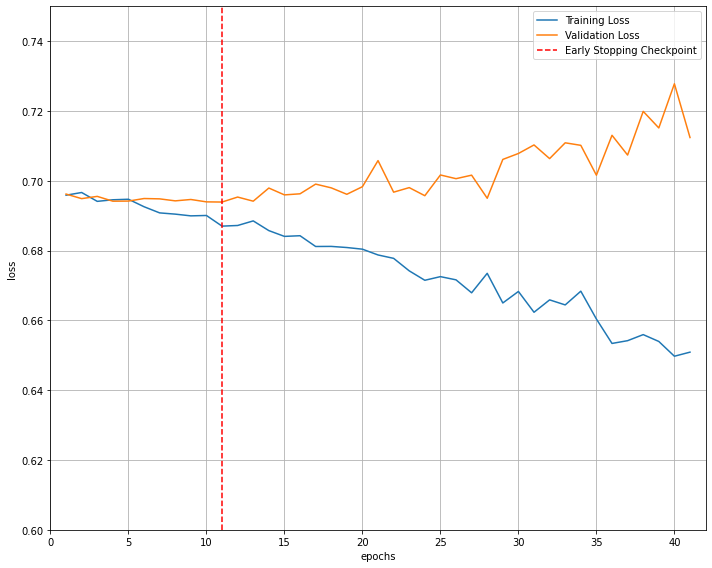

[  0/100] train_loss: 0.69795 valid_loss: 0.69981
Validation loss decreased (inf --> 0.699812).  Saving model ...
[  1/100] train_loss: 0.69434 valid_loss: 0.69876
Validation loss decreased (0.699812 --> 0.698765).  Saving model ...
[  2/100] train_loss: 0.69524 valid_loss: 0.69986
EarlyStopping counter: 1 out of 30
[  3/100] train_loss: 0.69311 valid_loss: 0.70045
EarlyStopping counter: 2 out of 30
[  4/100] train_loss: 0.69521 valid_loss: 0.69936
EarlyStopping counter: 3 out of 30
[  5/100] train_loss: 0.69187 valid_loss: 0.70100
EarlyStopping counter: 4 out of 30
[  6/100] train_loss: 0.69224 valid_loss: 0.69954
EarlyStopping counter: 5 out of 30
[  7/100] train_loss: 0.69394 valid_loss: 0.69814
Validation loss decreased (0.698765 --> 0.698139).  Saving model ...
[  8/100] train_loss: 0.69056 valid_loss: 0.69931
EarlyStopping counter: 1 out of 30
[  9/100] train_loss: 0.69004 valid_loss: 0.70026
EarlyStopping counter: 2 out of 30
[ 10/100] train_loss: 0.68838 valid_loss: 0.70034
Ear

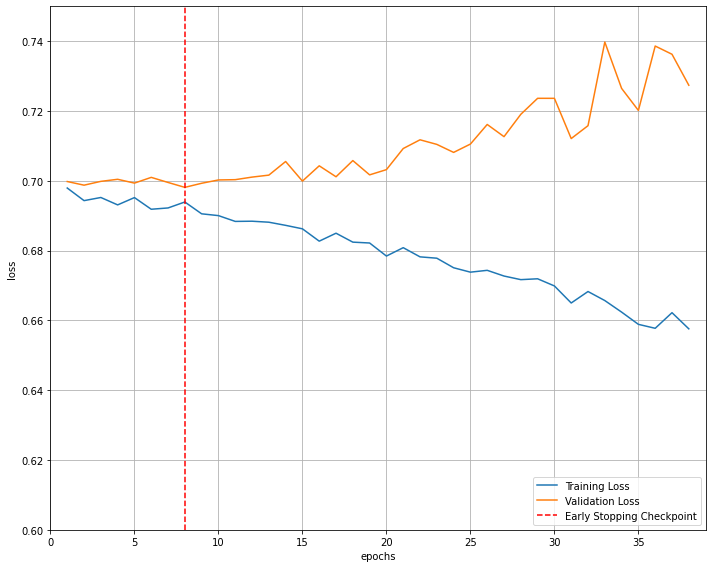

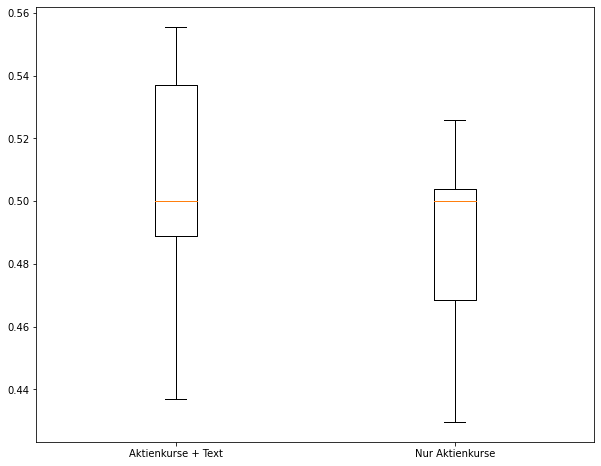

15.0 0.3742593192802244


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [ ]:
eval_df = pd.DataFrame({'Run Number' : [], 'Stock Only': [], 'Test Accuracy': []}) # Collect results
for run_type in run_types:
  STOCK_ONLY = run_type
  train, validation, test = prepare_data("all_articles_filtered.csv", "utf-8")
  for run in range(1, num_runs+1):  
    model = LSTM_Classifier(EMBEDDING_DIM, HIDDEN_DIM, 1)
    model.to(device)
    loss_function = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    model, train_loss, valid_loss = train_model(model, patience)
    plot_loss(train_loss, valid_loss, STOCK_ONLY, run)
    accuracy = eval_model(model, test)
    eval_df = eval_df.append({"Run Number": run, "Stock Only": STOCK_ONLY, "Test Accuracy": accuracy}, ignore_index=True)

stock_only = eval_df[eval_df["Stock Only"] == 1]
stock_and_text = eval_df[eval_df["Stock Only"] == 0]

fig = plt.figure(figsize=(10,8))
labels = ["Aktienkurse + Text", "Nur Aktienkurse"]
plt.tight_layout()
plt.boxplot((stock_and_text["Test Accuracy"],stock_only["Test Accuracy"]), labels=labels)
plt.show()
fig.savefig(BASEPATH+'/eval_plot_50_runs.png', bbox_inches='tight')
eval_df.to_csv(BASEPATH+"/eval_df.csv")

w, p = wilcoxon(stock_and_text["Test Accuracy"], stock_only["Test Accuracy"])
print(w, p)
f = open(BASEPATH+"/wilcoxon.txt", "w")
f.write("Ergebnis Wilcoxon Signed Rank Test: w="+str(w)+" p="+str(p))
f.close()

In [ ]:
stock_and_text

,Run Number,Stock Only,Test Accuracy
10,1.0,0.0,0.496296
11,2.0,0.0,0.488889
12,3.0,0.0,0.437037
13,4.0,0.0,0.548148
14,5.0,0.0,0.540741
15,6.0,0.0,0.503704
16,7.0,0.0,0.555556
17,8.0,0.0,0.525926
18,9.0,0.0,0.488889
19,10.0,0.0,0.474074


In [ ]:
stock_only

,Run Number,Stock Only,Test Accuracy
0,1.0,1.0,0.496296
1,2.0,1.0,0.429630
2,3.0,1.0,0.525926
3,4.0,1.0,0.503704
4,5.0,1.0,0.503704
5,6.0,1.0,0.466667
6,7.0,1.0,0.474074
7,8.0,1.0,0.451852
8,9.0,1.0,0.503704
9,10.0,1.0,0.518519
